In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report ,accuracy_score ,confusion_matrix 
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import joblib
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

In [2]:
path=r'D:\Maim\textclassification\bbc'

In [3]:
texts=[]
labels=[]

for category in os.listdir(path):
    category_path=os.path.join(path,category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            file_path=os.path.join(category_path,file)
            with open(file_path,'r',encoding='latin1') as file :
                content=file.read()
                texts.append(content)
                labels.append(category)

df=pd.DataFrame({'text':texts,'label':labels})
df=df.sample(frac=1,random_state=42).reset_index(drop=True) # shuffle the rows
print(df.head())

                                                text     label
0  UK house prices dip in November\n\nUK house pr...  business
1  LSE 'sets date for takeover deal'\n\nThe Londo...  business
2  Harinordoquy suffers France axe\n\nNumber eigh...     sport
3  Barclays shares up on merger talk\n\nShares in...  business
4  Campaign 'cold calls' questioned\n\nLabour and...  politics


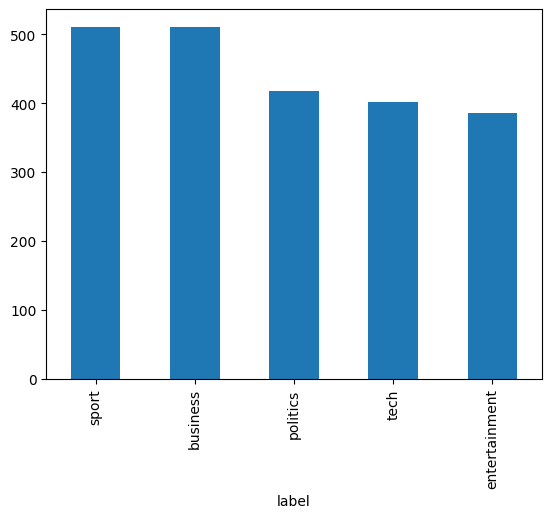

In [4]:
df['label'].value_counts().plot(kind='bar')
plt.show()

In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) # only remove not replace 
    text = re.sub(r'\d+', '', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)
print(df[['text', 'clean_text']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mmahm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mmahm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mmahm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mmahm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  UK house prices dip in November\n\nUK house pr...   
1  LSE 'sets date for takeover deal'\n\nThe Londo...   
2  Harinordoquy suffers France axe\n\nNumber eigh...   
3  Barclays shares up on merger talk\n\nShares in...   
4  Campaign 'cold calls' questioned\n\nLabour and...   

                                          clean_text  
0  uk house price dip november uk house price dip...  
1  lse set date takeover deal london stock exchan...  
2  harinordoquy suffers france axe number eight i...  
3  barclays share merger talk share uk banking gr...  
4  campaign cold call questioned labour conservat...  


In [6]:
df.drop(columns='text',inplace=True)
df.head()

,label,clean_text
0,business,uk house price dip november uk house price dip...
1,business,lse set date takeover deal london stock exchan...
2,sport,harinordoquy suffers france axe number eight i...
3,business,barclays share merger talk share uk banking gr...
4,politics,campaign cold call questioned labour conservat...


In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
print("Shape of TF-IDF matrix:", X.shape) # 2225  documantry 30564 word 
tfidf_array = X.toarray()


Shape of TF-IDF matrix: (2225, 27882)


In [8]:
y = df['label']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
nb = MultinomialNB()
nb_param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

nb_grid = GridSearchCV(nb,param_grid=nb_param_grid,cv=5,scoring='accuracy')
nb_grid.fit(X_train, y_train)

print("\n=== Naive Bayes Results ===")
print("Best Params:", nb_grid.best_params_)
print("Best Accuracy:", nb_grid.best_score_)

log_param_grid = {
    'C': [0.01, 0.1, 1, 10,100],
    'solver': ['lbfgs', 'liblinear','newton-cg']
}
log_grid=LogisticRegression()
log_grid = GridSearchCV(log_grid,param_grid=log_param_grid, cv=5, scoring='accuracy')
log_grid.fit(X_train, y_train)

print("\n=== Logistic Regression Results ===")
print("Best Params:", log_grid.best_params_)
print("Best Accuracy:", log_grid.best_score_)





=== Naive Bayes Results ===
Best Params: {'alpha': 0.1}
Best Accuracy: 0.9775280898876403

=== Logistic Regression Results ===
Best Params: {'C': 100, 'solver': 'lbfgs'}
Best Accuracy: 0.9808988764044944


In [ ]:
final_model=LogisticRegression(solver='lbfgs',C=100)
final_model.fit(X_train,y_train)
predict=final_model.predict(X_test)

In [11]:
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(final_model, "logistic_model.pkl")

['logistic_model.pkl']

In [15]:
accuracy_score(predict,y_test)

0.9617977528089887

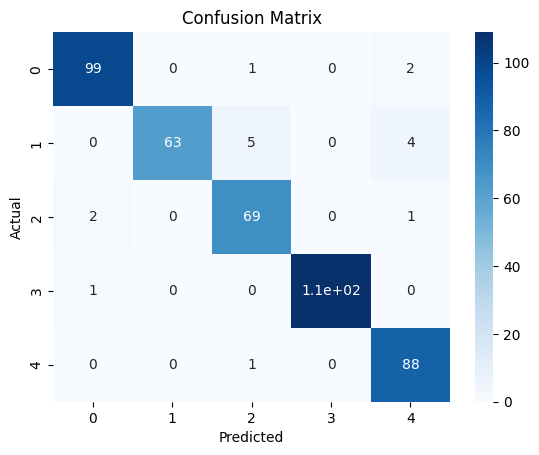

In [16]:
matrix=confusion_matrix(y_true=y_test,y_pred=predict)
sns.heatmap(matrix,annot=True,cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
print(classification_report(y_pred=predict,y_true=y_test))

               precision    recall  f1-score   support

     business       0.97      0.97      0.97       102
entertainment       1.00      0.88      0.93        72
     politics       0.91      0.96      0.93        72
        sport       1.00      0.99      1.00       110
         tech       0.93      0.99      0.96        89

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



Accuracy is a misleading metric in unbalanced data. The previous confusion matrix shows that not only is the accuracy high, but also the majority of predictions are of the majority class.

Recall:Out of all the actual positive cases, what percentage did we correctly predict? (positive is the true class)           
precision:Out of everything I predicted as positive, how many were actually correct?     
f1:is a harmonic mean of the both.                                  
The high values of the three metrics indicate that the model is good.

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [18]:
X_texts = df['clean_text']
y_labels = df['label_encoded']

X_train_texts, X_test_texts, y_train_labels, y_test_labels = train_test_split(
    X_texts, y_labels, test_size=0.2, random_state=42, shuffle=True
)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(X_train_texts), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test_texts), truncation=True, padding='max_length', max_length=512, return_tensors='pt')

train_labels = torch.tensor(list(y_train_labels))
test_labels = torch.tensor(list(y_test_labels))


In [19]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [21]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(X_train_texts), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test_texts), truncation=True, padding='max_length', max_length=512, return_tensors='pt')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [25]:
for epoch in range(3):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} done.")

Epoch 1 done.
Epoch 2 done.
Epoch 3 done.


In [ ]:
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.9708


In [ ]:
class_names = df['label'].unique().tolist()
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)



               precision    recall  f1-score   support

     business       0.96      0.96      0.96       102
entertainment       1.00      0.97      0.99        72
     politics       0.93      0.94      0.94        72
        sport       0.99      0.99      0.99       110
         tech       0.97      0.98      0.97        89

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



The difference in accuracy between the Logistic Regression and Transformer models isn’t significant, but the Transformer model still performs slightly better Precision is high across all classes in both models especially in Entertainment and Sports, indicating that both models are very good at correctly identifying positive instances in these categories. Recall shows a similar pattern but the F1-score is higher for the Transformer model than for Logistic Regression at the majority of classes  which indicates that the balance between precision and recall is better in the Transformer model.

## Ethics Check 


Potential bias in the training data may arise from imbalanced labels, particularly for popular topics. Misclassifications could mislead users or propagate misinformation if the model is used in news aggregation.

Mitigation:

We could use resampling techniques to balance the data. However, this is not necessary in our case because, although the dataset is somewhat imbalanced, all classes have a large number of samples, and the differences in the number of samples between classes are not very large.